# Анализ оттока клиентов банка

**Заказчик:** отдел маркетинга

**Проблема:** отток клиентов

**Задача:** выявить сегменты клиентов, склонных к оттоку, и сформировать рекомендации по их удержанию

Исследование проводится на данных о клиентах банка.<br>
Описание данных:<br>
* USERID — идентификатор пользователя
* score — баллы кредитного скоринга
* city — город
* gender — пол
* age — возраст
* equity — количество баллов собственности
* balance — баланс на счете
* products — количество продуктов, которыми пользуется клиент
* credit_card — есть ли кредитная карта
* last_activity — был ли клиент активен в последнее время
* EST_SALARY — оценочный доход клиента
* сhurn — признак оттока <br>


План работы:<br>
1. [Загрузка данных](#start)<br>
2. [Предобработка данных](#preprocessing)<br>
3. [Исследовательский анализ данных](#exploration)<br>
4. [Проверка гипотез, связанных с оттоком](#hypotheses)<br>
5. [Сегментация клиентов](#segmenting)<br>
6. [Выводы и рекомендации](#summary)

In [1]:
# загрузим необходимые для работы библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import mode
import phik
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings

In [2]:
# скроем предупреждения
warnings.filterwarnings('ignore')

In [3]:
# уберем научную нотацию при выводе вещественныъх чисел
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### <a id="start">Загрузка данных</a>
<br>
Откроем файлы с данными и изучим общую информацию.

In [4]:
# откроем датасет
data = pd.read_csv(r'C:\Users\Valentina\pr\pr_env\projects\bank churn\bank_clients_data.csv')

# выведем первые строки и изучим общую информацию
display(data.head())
data.info()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Необходимо привести столбцы к единому виду, закодировать некоторые признаки и обработать пропуски. 

### <a id="preprocessing">Предобработка данных</a>
<br>
Исправим названия столбцов.

In [5]:
# переведем названия столбцов в нижний регистр и выведем список столбцов для проверки
data.columns = [x.lower() for x in data.columns]
list(data)

['userid',
 'score',
 'city',
 'gender',
 'age',
 'equity',
 'balance',
 'products',
 'credit_card',
 'last_activity',
 'est_salary',
 'churn']

Для дальнейшей работы численно закодируем данные в столбцах `city` и `gender`.

In [6]:
# скопируем исходные столбцы, чтобы они остались в датафрейме
data[['city1', 'gender1']] = data[['city', 'gender']]

# закодируем данные
data = pd.get_dummies(data, columns=['city1'], drop_first=False, dtype=int)
data = pd.get_dummies(data, columns=['gender1'], drop_first=True, dtype=int)

# переименуем полученные столбцы
data = data.rename(
    columns = {'city1_Ростов':'rostov', \
               'city1_Рыбинск':'rybinsk', \
               'city1_Ярославль':'yaroslavl', \
              'gender1_М':'gender_code'}
)
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_code
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1,0,1,0,0
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0,0,1,0,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0,0,1,0,0
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1,0,0,1,0
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1,0,0,1,1


Перейдем к пропускам. Они присутствуют в 2 столбцах: с возрастом и балансом. В столбце с возрастом всего 26 пропусков - очень незначительная часть от всего датасета, от этих строк проще избавиться, чем тратить время на их обработку.

In [7]:
# удалим строки с пропусками в столбце age
data = data.dropna(subset=['age']).reset_index(drop=True)

Изменим тип данных в столбце с возрастом.

In [8]:
# приведем данные в столбце age к целочисленному типу
data['age'] = data['age'].astype('int')

Чтобы проанализировать пропуски в столбце `balance`, создадим столбец с признаком наличия пропуска.

In [9]:
# создадим новый столбец, где 1 - пропуск баланса
data['balance_missing'] = np.where(data['balance'].isna(), 1, 0)

Выведем таблицу со средними значениями для клиентов, баланс которых известен, и клиентов с пропусками в балансе.

In [10]:
# сгруппируем данные по наличию информации о балансе и выведем средние
data.groupby('balance_missing').agg(
    {'score':'mean',
     'city': pd.Series.mode,
     'gender': pd.Series.mode,
     'age':'median',
     'equity':'median',
     'products':'median',
     'credit_card':'median',
     'last_activity':'median',
     'est_salary':['mean', 'median'],
     'churn':'median'}
).T.rename(columns={0:'Есть данные', 1:'Нет данных'})

balance_missing      Есть данные Нет данных
score         mean        843.74     865.36
city          mode     Ярославль  Ярославль
gender        mode             Ж          М
age           median       40.00      40.00
equity        median        4.00       0.00
products      median        2.00       1.00
credit_card   median        1.00       1.00
last_activity median        1.00       1.00
est_salary    mean     124520.39  226345.42
              median   106250.18  174347.87
churn         median        0.00       0.00

Сразу обращает на себя внимание разница в баллах собственности и оценке дохода. У клиентов, для которых информация о балансе отсутствует, нулевой медианный балл собственности по сравнению с баллом 4 у второй группы клиентов, а средний оценочный доход значительно выше. Т.е. доход высокий, а собственности как будто нет. Или, вполне возможно, просто отсутствует информация об этой собственности. Посмотрим на корреляцию признаков, отличающихся в разрезе наличия информации о балансе.

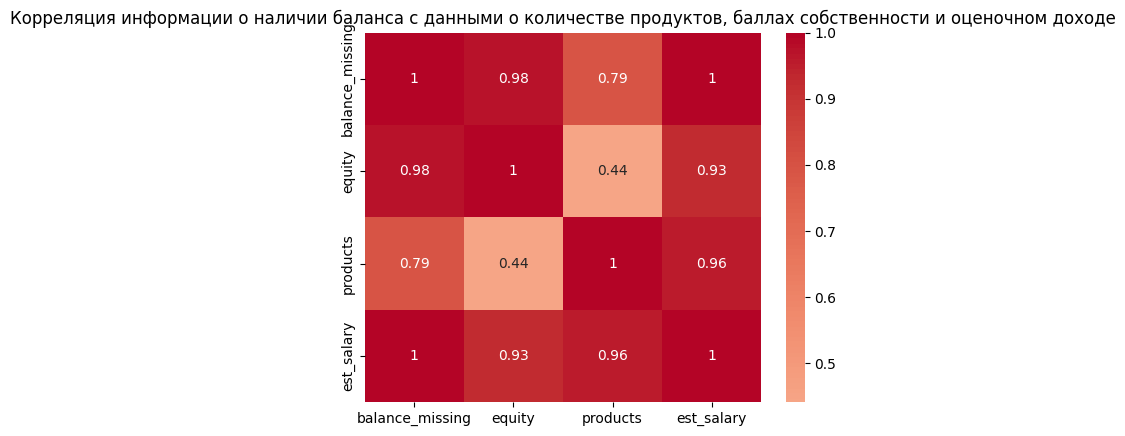

In [11]:
# построим тепловую карту для интересующих столбцов по матрице корреляции
ax = sns.heatmap(
    data[['balance_missing', 'equity', 'products', 'est_salary']]
    .phik_matrix(interval_cols='est_salary'), 
    cmap='coolwarm',
    center=0,
    annot=True
)
ax.set(
    title='Корреляция информации о наличии баланса с данными о количестве продуктов, баллах собственности и оценочном доходе'
);

Наблюдение о взаимосвязи баллов собственности и отсутствии информации о балансе подтвердилось, но смущает очень высокая корреляция с оценочным доходом. Выведем информацию о доходе с разбивкой по наличию данных о балансе. 

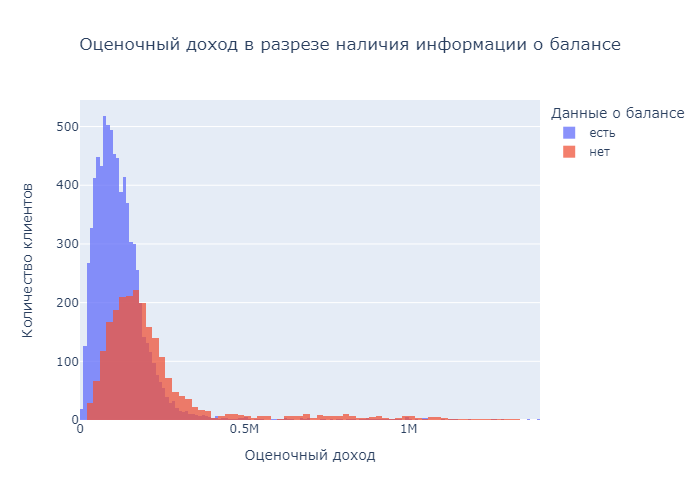

In [12]:
# построим гистограмму оценочного дохода с группировкой по наличию данных о балансе
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data.query('balance_missing == 0')['est_salary'],
    name='есть'
))

fig.add_trace(go.Histogram(
    x=data.query('balance_missing == 1')['est_salary'],
    name='нет'
))

fig.update_layout(
    barmode='overlay',
    title='Оценочный доход в разрезе наличия информации о балансе',
    title_x=.5,
    yaxis_title='Количество клиентов',
    xaxis_title='Оценочный доход',
    legend_title='Данные о балансе'
)
fig.update_traces(opacity=0.75)
fig.show('png')

In [13]:
# выведем количество записей для доходов свыше 200 тысяч
data[data['est_salary'] > 200000]['balance_missing'].value_counts()

balance_missing
0    877
1    869
Name: count, dtype: int64

Можно заключить, что по мере роста дохода доля отсутствующей информации о балансе действительно растет. А баллы собственности и количество продуктов при отсутствующей информации о балансе и, соответственно, оценочном доходе минимальны. Таким образом, хотя часть информации о балансе могла быть утрачена случайным образом, например, в результате ошибки или технического сбоя, зависимость все же прослеживается, т.е. пропуски нельзя назвать случайными. Они встречаются у клиентов с относительно высокими оценочными доходами, но с низким баллом собственности и малым количеством продуктов. Могут эти клиенты пользоваться каким-то продуктом, при котором баланс не отображается? Мы не можем этого сказать на основе имеющихся данных. Однако очевидно, что записи с пропущенным балансом важны, от них нельзя избавиться, но и заполнить синтетическими значениями также не представляется возможным. Придется оставить их в датасете как есть.

Проверим датасет на наличие дубликатов.

In [14]:
# найдем явные дубликаты
data.duplicated().sum()

0

In [15]:
# выведем неявные дубликаты по userid
data[data.duplicated(subset='userid', keep=False)].sort_values(by='userid')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_code,balance_missing
1892,116540,883.00,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1,0,1,0,0,0
7683,116540,887.00,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0,0,0,1,0,1
4862,117943,855.00,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1,0,1,0,0,0
7531,117943,880.00,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0,0,0,1,0,1
5856,120258,908.00,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300,220816,934.00,Рыбинск,Ж,74,5,1294285.39,3,1,0,95606.80,0,0,1,0,0,0
2594,226719,990.00,Ярославль,М,37,4,14648692.14,2,0,0,934412.61,1,0,0,1,1,0
4212,226719,903.00,Рыбинск,Ж,63,0,NaN,1,1,0,138582.58,0,0,1,0,0,1
8192,227795,840.00,Рыбинск,М,34,2,350768.03,1,1,0,102036.14,1,0,1,0,1,0


В датасете довольно дублей по номеру клиента, однако у дублей зачастую не совпадают город, возраст, пол и другие параметры. Все клиенты действующие, поэтому нельзя сказать, что номер просто передали от ушедшего клиента действующему. Возможно, дублирование номеров возникло из-за ввода данных в разных городах. Проверим, будут ли дубли по паре номер клиента - город.

In [16]:
# выведем неявные дубликаты по userid + city
data[data.duplicated(subset=['userid', 'city'], keep=False)].sort_values(by='userid')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_code,balance_missing


Как видим, дубли в рамках одного города отсутствуют. То есть можно предположить какой-то сбой в нумерации клиентов между двумя городами, а задвоение клиентских номеров нельзя считать дублированием. 

Проверим датасет на наличие аномалий.

In [17]:
# создадим цикл для вывода уникальных категориальных значений
for col in data.columns:
    if data[col].dtype == 'object':
        print(data[col].sort_values().unique())
    else:
        pass

['Ростов' 'Рыбинск' 'Ярославль']
['Ж' 'М']


В категориальных данных проблем нет, что, впрочем, косвенно подтвердилось в ходе выполнения предыдущих операций.

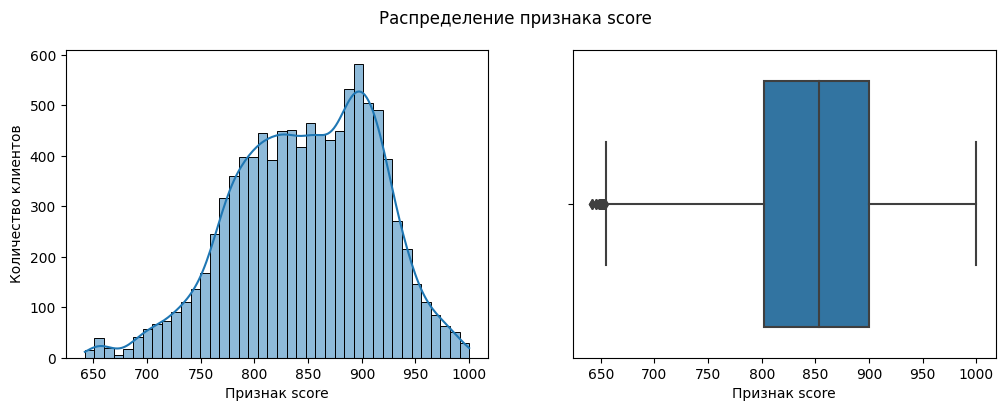

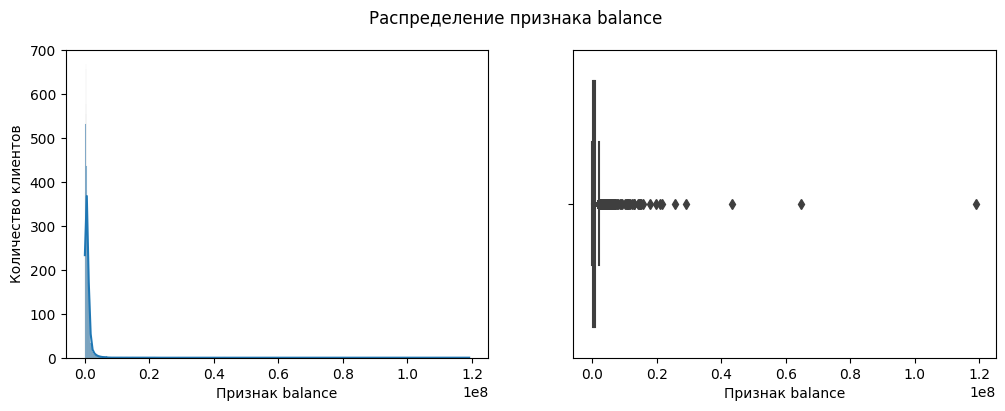

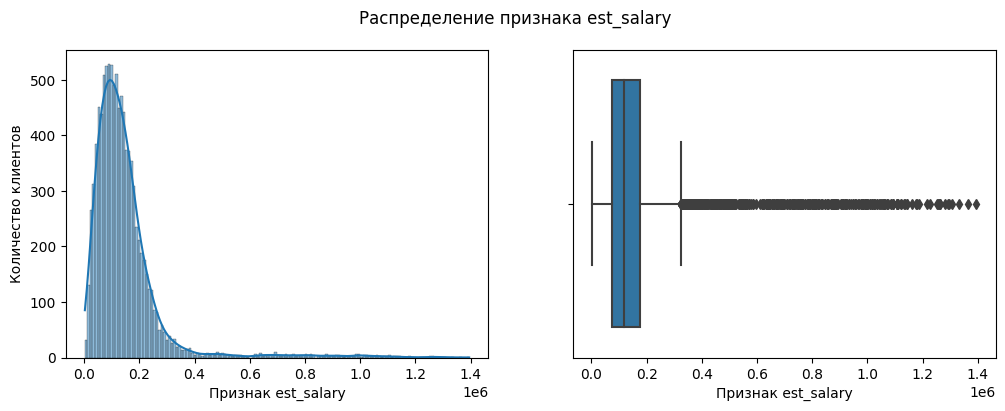

In [18]:
# создадим цикл для вывода гистограмм и диаграмм размаха для столбцов с непрерывными значениями
for col in data.columns:
    if data[col].dtype == 'float64':       
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        sns.histplot(data=data, x=col, kde=True, ax=axes[0])
        axes[0].set_xlabel('Признак {}'.format(col))
        axes[0].set_ylabel('Количество клиентов')
        sns.boxplot(data=data, x=col, ax=axes[1])
        axes[1].set_xlabel('Признак {}'.format(col))
        plt.suptitle('Распределение признака {}'.format(col))
        plt.show()
    else:
        pass

В столбце с кредитным скорингом практически нормальное распределение, а для баланса и оценочного дохода видим длинные хвосты выбросов. Изучим статистику по ним.

In [19]:
# выведем статистические данные по столбцам с непрерывными значениями
data.describe(include=[float], percentiles=[.25, .5, .75, .95])

,score,balance,est_salary
count,9974.00,7695.00,9974.00
mean,848.68,827245.59,147786.81
std,65.40,1980327.41,139285.51
min,642.00,0.00,2546.30
25%,802.00,295698.71,75251.66
50%,853.00,524295.33,119626.79
75%,900.00,980051.21,174499.81
95%,946.00,2114078.39,316360.58
max,1000.00,119113552.01,1395064.45


В данных о балансе и оценочном доходе наблюдаем большой разброс. Чтобы проверить влияние выбросов на отток, изучим параметры оттока для верхних 25% и 5% баланса и дохода.

In [20]:
# вычислим среднее значение оттока по банку
mean_churn = (
    data
    .agg({"churn":["mean","sum","count"]})
    .rename(columns={'churn':'среднее по банку'})
)

# вычислим среднее значение оттока по топ25% баланса
top25_balance = (
    data
    .query('balance >= 980051.21')
    .agg({"churn":["mean","sum","count"]})
    .rename(columns={'churn':'топ25% баланса'})
)

# вычислим среднее значение оттока по топ5% баланса
top5_balance = (
    data
    .query('balance >= 2114078.39')
    .agg({"churn":["mean","sum","count"]})
    .rename(columns={'churn':'топ5% баланса'})
)

# вычислим среднее значение оттока по топ25% дохода
top25_salary = (
    data
    .query('est_salary >= 174499.81')
    .agg({"churn":["mean","sum","count"]})
    .rename(columns={'churn':'топ25% дохода'})
)

# вычислим среднее значение оттока по топ5% дохода
top5_salary = (
    data
    .query('est_salary >= 316360.58')
    .agg({"churn":["mean","sum","count"]})
    .rename(columns={'churn':'топ5% дохода'})
)

# объединим датафреймы и выведем итоговую таблицу
top_churn = mean_churn.join([top25_balance, top25_salary, top5_balance, top5_salary])
top_churn

,среднее по банку,топ25% баланса,топ25% дохода,топ5% баланса,топ5% дохода
mean,0.18,0.38,0.19,0.49,0.16
sum,1819.00,738.00,470.00,187.00,82.00
count,9974.00,1924.00,2494.00,385.00,499.00


Похоже, доля оттока увеличивается по мере роста баланса. С ростом дохода доля оттока практически не меняется, однако удаление клиентов с высоким доходом может сместить распределения в датасете, поэтому оставим выбросы.

Выведем информацию о бинарных признаках.

In [21]:
data[['credit_card', 'last_activity', 'churn']].nunique()

credit_card      2
last_activity    2
churn            2
dtype: int64

У таких признаков только 2 значения - 0 и 1, то есть аномалии отсутствуют.<br>

Наконец, изучим порядковые признаки.

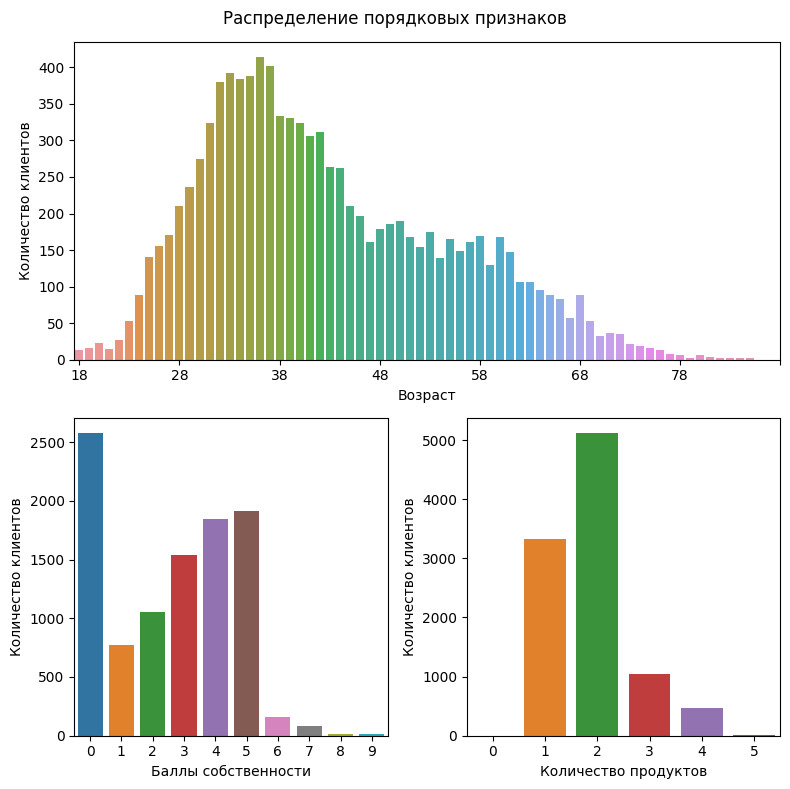

In [22]:
# построим диаграммы распределения порядковых признаков
fig = plt.figure(figsize=(8, 8), tight_layout=True)
spec = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(spec[0, :])
sns.countplot(data=data, x='age', ax=ax0)
ax0.set(xticks=[0, 10, 20, 30, 40, 50, 60, 70])
ax0.set(xlabel='Возраст', ylabel='Количество клиентов')

ax10 = fig.add_subplot(spec[1, 0])
sns.countplot(data=data, x='equity', ax=ax10)
ax10.set(xlabel='Баллы собственности', ylabel='Количество клиентов')

ax11 = fig.add_subplot(spec[1, 1])
sns.countplot(data=data, x='products', ax=ax11)
ax11.set(xlabel='Количество продуктов', ylabel='Количество клиентов')

plt.suptitle('Распределение порядковых признаков')
plt.show()

Возраста распределены нормально, аномальных значений нет. <br>
В баллах собственности много нулевых значений, которым соответствует нулевой баланс. Это снова наталкивает на мысль, что здесь данные скорее отсутствуют, нежели указывают на реальную оценку собственности. Количество записей резко снижается, начиная с 6, при том, что в целом распределение выглядит нормальным. Возможные причины: 1. методика оценки, по которой на границе 5-6 располагается переход на некий качественно иной уровень 2. недостающие данные скрываются в значении 0. Вероятно, в дальнейшем нужно будет учесть, что 0 здесь совсем не обязательно указывает на "плохое" качество собственности. <br>
Что касается количества продуктов, как уже упоминалось, все клиенты действующие, т.е. минимум 1 продукт у них должен быть. Соответственно, наличие значения 0 указывает на ошибку. Выведем соответствующие строки.

In [23]:
# выведем строки с нулевым количеством продуктов
data[data['products'] == 0]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_code,balance_missing
8939,147837,962.00,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,0,1,0,0,1


У клиента нет продуктов, при этом он/она находится в оттоке. Скорее всего, это уже не клиент банка. Избавимся от строки.

In [24]:
# удалим строку с нулевым количеством продуктов
data = data.drop(data[data['products'] == 0].index).reset_index(drop=True)
data

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_code,balance_missing
0,183012,850.00,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,0,0
1,146556,861.00,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,0,0
2,120722,892.00,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,0,1
3,225363,866.00,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,0,0
4,157978,730.00,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9968,120553,814.00,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0,0,1,0,1,0
9969,139170,894.00,Ярославль,М,46,0,NaN,1,1,0,196898.29,0,0,0,1,1,1
9970,115639,903.00,Ярославль,М,24,0,NaN,2,1,1,108905.09,0,0,0,1,1,1
9971,148700,777.00,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0,0,0,1,0,0


Мы подготовили данные к дальнейшему анализу:
- привели столбцы к змеиному регистру,
- закодировали категориальные столбцы,
- обработали пропуски: 
    - в т.ч. удалили строки, где это было допустимо,
- проверили датасет на дубликаты,
- проверили датасет на аномалии:
    - удалили неправдоподобные значения, где это было возможно.

### <a id="exploration">Исследовательский анализ данных</a>

#### Портрет клиента в разрезе оттока

Изучим средние тенденции для отточных и неотточных клиентов.

In [25]:
# сгруппируем данные по оттоку и выведем средние
data.groupby('churn').agg(
    {'score':['mean', 'median'],
     'city': pd.Series.mode,
     'gender': pd.Series.mode,
     'age':'median',
     'balance':['mean', 'median'],
     'equity':'median',
     'products':'median',
     'credit_card':'median',
     'last_activity':'median',
     'est_salary':['mean', 'median']}
).T.rename(columns={0:'Не отток', 1:'Отток'})

churn                  Не отток      Отток
score         mean       845.40     863.36
              median     848.00     866.00
city          mode    Ярославль  Ярославль
gender        mode            Ж          М
age           median      40.00      39.00
balance       mean    733031.63 1134458.21
              median  475410.09  783908.90
equity        median       3.00       4.00
products      median       2.00       2.00
credit_card   median       1.00       1.00
last_activity median       0.00       1.00
est_salary    mean    147674.64  148357.48
              median  118227.60  125408.88

Судя по средним, у отточных клиентов чуть выше кредитный рейтинг, хотя разница не превышает 20 пунктов. В отток чаще попадают мужчины с гораздо более внушительным балансом, чем у неотточных клиентов, более высоким баллом собственности и более высокой активностью. Разница в доходах у отточных и неотточных клиентов незначительна.

#### Непрерывные значения в разрезе оттока

Изучим распределение непрерывных значений и значений возраста.

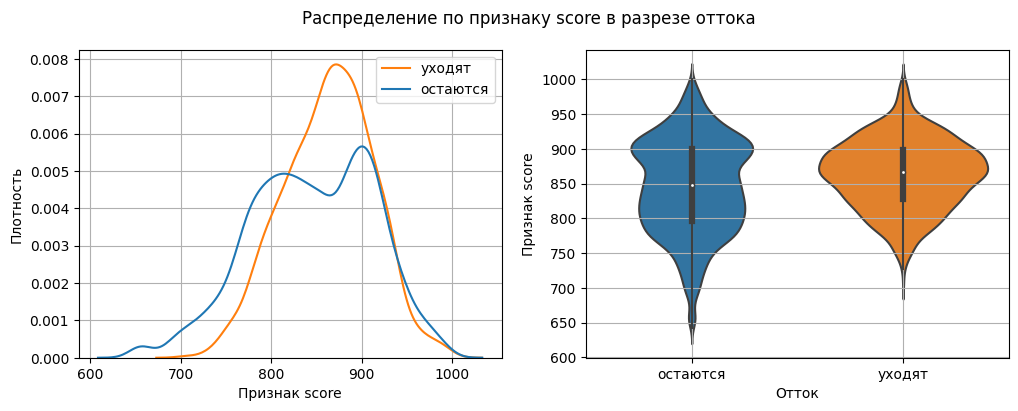

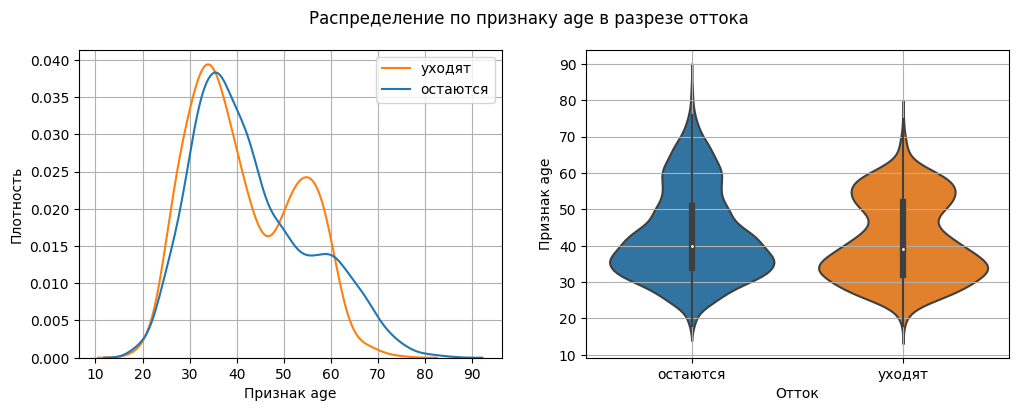

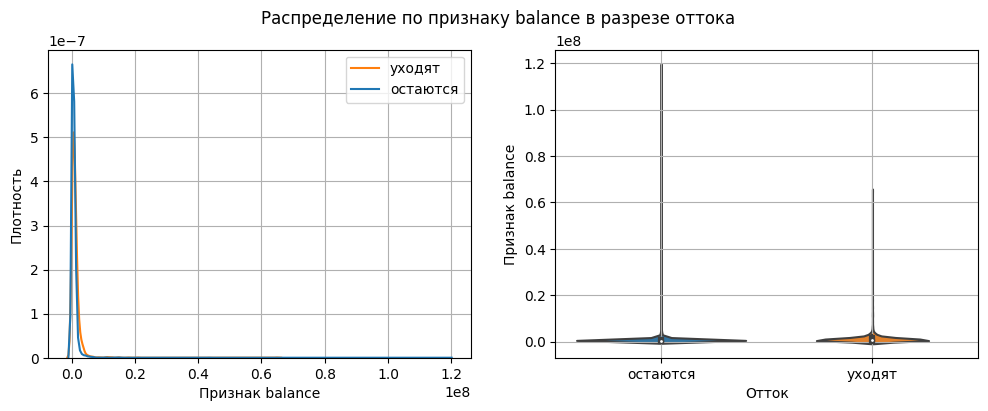

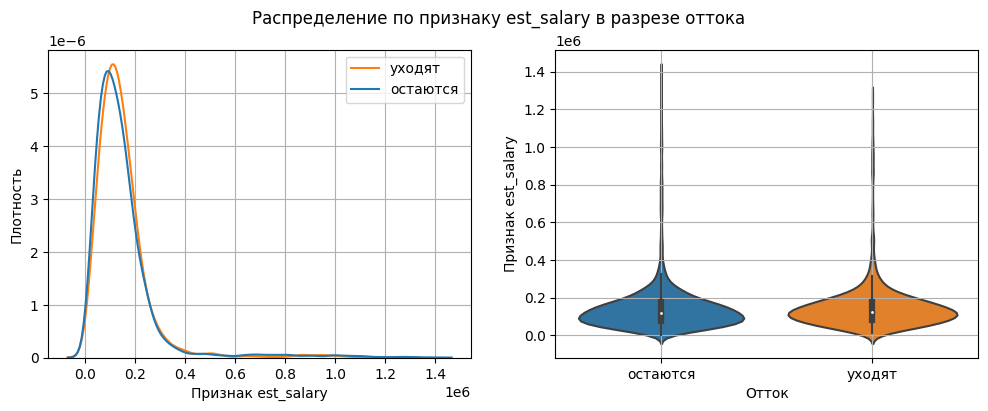

In [26]:
# создадим цикл для вывода kde-графиков и скрипичных диаграмм
for col in data.columns:
    if data[col].dtype == 'float64' or col == 'age': 
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        sns.kdeplot(data=data, x=col, hue='churn', common_norm=False, ax=axes[0])
        axes[0].legend(labels=['уходят', 'остаются'])
        axes[0].set_xlabel('Признак {}'.format(col))
        axes[0].set_ylabel('Плотность')
        axes[0].grid()
        sns.violinplot(data=data, y=col, x='churn', ax=axes[1])
        axes[1].set_ylabel('Признак {}'.format(col))
        axes[1].set_xlabel('Отток')
        axes[1].set_xticklabels(['остаются', 'уходят'])
        plt.grid()
        plt.suptitle('Распределение по признаку {} в разрезе оттока'.format(col))
        plt.show()

Диаграмма баланса получилась малоинформативной. Рассмотрим ее подробнее.

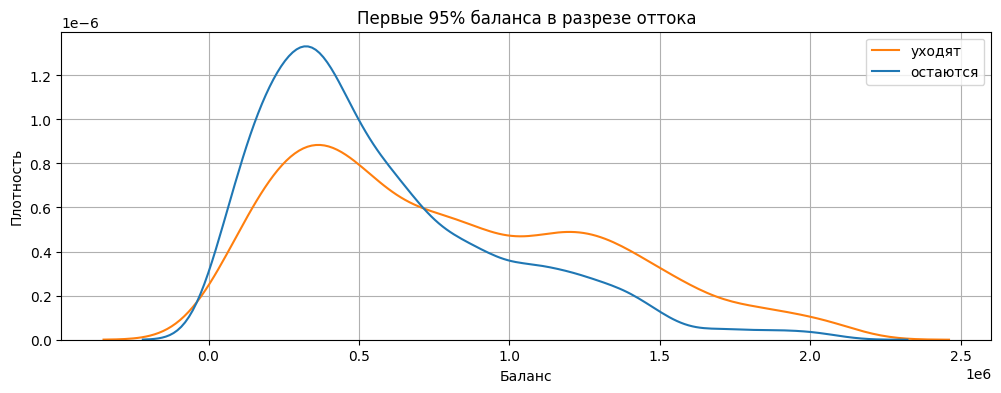

In [27]:
# kde-график для 95% датасета по балансу
fig, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(data=data.query('balance <= 2114078.39'),
             x='balance', 
             hue='churn', 
             common_norm=False)
ax.legend(labels=['уходят', 'остаются'])
ax.set_xlabel('Баланс')
ax.set_ylabel('Плотность')
ax.set_title('Первые 95% баланса в разрезе оттока')
ax.grid()
plt.show()

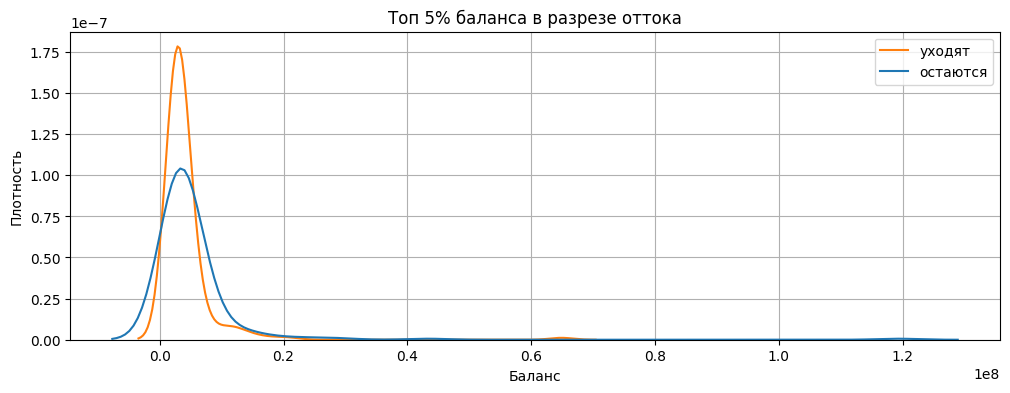

In [28]:
# kde-график для топ5% датасета по балансу
fig, ax = fig, axes = plt.subplots(figsize=(12, 4))
sns.kdeplot(data=data.query('balance > 2114078.39'),
             x='balance', 
             hue='churn', 
             common_norm=False)
ax.legend(labels=['уходят', 'остаются'])
ax.set_xlabel('Баланс')
ax.set_ylabel('Плотность')
ax.set_title('Топ 5% баланса в разрезе оттока')
ax.grid()
plt.show()

**Кредитный скоринг**: доля оттока выше среди клиентов с баллами примерно от 820 до 910. Такое количество баллов у подавляющего большинства клиентов. Примечательно, что среди клиентов с самым низким рейтингом доля оттока стремится к нулю и резко снижается среди клиентов с самым высоким.<br>
**Возраст**: доля оттока существенно выше в возрастной категории 50-60. Также высокая доля оттока наблюдается в возрастах ~23-35 лет.<br>
**Баланс**: доля оттока стабильно выше от 750тыс и примерно до 6млн. На последней диаграмме видим, что после 6млн доля оттока снижается, однако в этом диапазоне значений очень мало и они обладают сильной вариативностью, т.е. каждое новое будет смещать кривую. Здесь имеет смысл опираться на среднее значение оттока, которое в для топ 5% баланса составляет 49%.<br>
**Оценочный доход**: доля оттока несколько выше при доходе от 100 до 200 тыс. В остальном линии на графике практически совпадают.

#### Категориальные значения в разрезе оттока

Изучим распределение оттока для категориальных и бинарных значений.

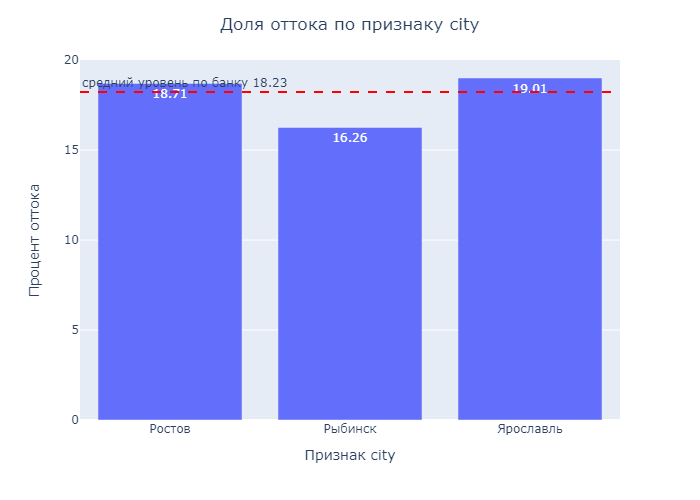

In [29]:
# создадим функцию для вывода столбчатой диаграммы с долями оттока по категориям
def cat_features(df, col):
    pivot = (df.groupby(col).agg({'churn':'mean'})*100).reset_index().round(2) # сводная таблица с подсчетом доли оттока
    fig = px.bar(
        pivot, 
        x=col, 
        y='churn', 
        text='churn',
    )
    fig.update_layout(
        title='Доля оттока по признаку {}'.format(col),
        title_x=.5,
        yaxis_title='Процент оттока',
        xaxis_title='Признак {}'.format(col),
        height=500,
        width=700
    )
#     линия среднего оттока по банку
    fig.add_hline(
        y=df['churn'].mean()*100, 
        line_dash='dash',
        line_color='red',
        annotation_text='средний уровень по банку {}'.format((df['churn'].mean()*100).round(2)), 
        annotation_position='top left')
# настройка вывода с подписями для отдельных столбцов    
    if col == 'credit_card':
        fig.update_layout(
            xaxis = dict(
            tickmode = 'array',
            tickvals = [0, 1],
            ticktext = ['нет', 'есть']
        ))
        fig.show('png')
    elif col == 'last_activity':
        fig.update_layout(
            xaxis = dict(
            tickmode = 'array',
            tickvals = [0, 1],
            ticktext = ['неактивен', 'активен']
        ))
        fig.show('png')
    else:
        fig.show('png')

   
# построим диаграмму для городов   
cat_features(data, 'city')

В Ростове и Ярославле доля оттока незначительно превышает среднее по банку. В Рыбинске отток ниже, но разница невелика (16,26% против 18,7% и 19% для Ростова и Ярославля соответственно). 

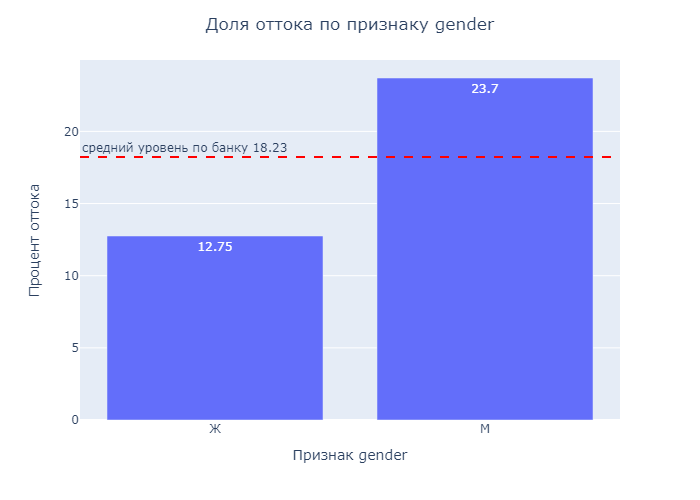

In [30]:
# построим диаграмму по полам
cat_features(data, 'gender') 

У мужчин отток почти в два раза выше, чем у женщин (23,7% против 12,75%).

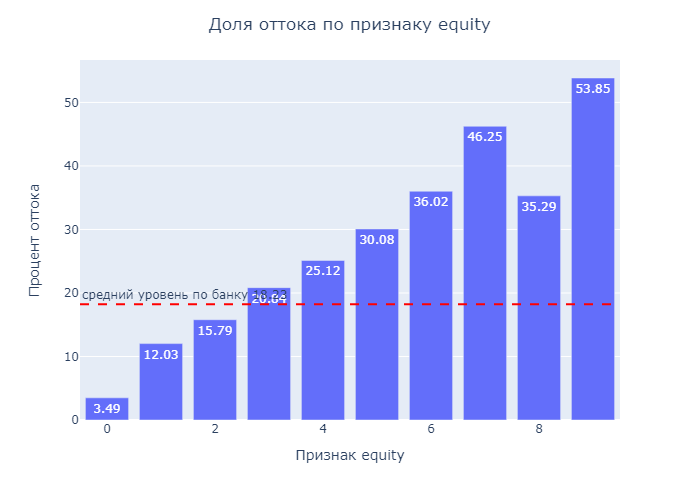

In [31]:
# построим диаграмму по баллам собственности
cat_features(data, 'equity') 

Наблюдаем практически линейный рост оттока по мере увеличения балла собственности. В верхних баллах малое число наблюдений, что может объяснить сильный разброс в долях оттока. Также следует помнить, что "нулевой" балл собственности присвоен многим клиентам с отсутствующей информацией о балансе.

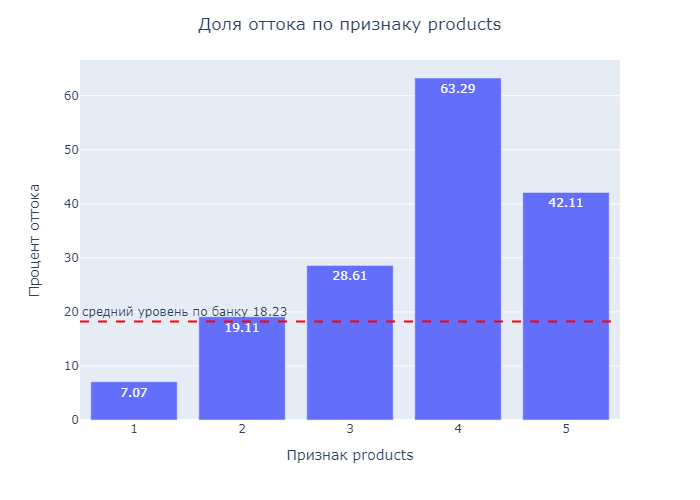

In [32]:
# построим диаграмму по количеству продуктов
cat_features(data, 'products') 

Клиентов с 4 и 5 продуктами мало, однако в этих категориях доля оттока зашкаливает. Также плохая ситуация среди клиентов с 3 продуктами, а это около 10% от всего датасета. У половины датасета 2 продукта, отток там чуть выше среднего значения. Наконец, у клиентов с 1 продуктом отток всего 7%.

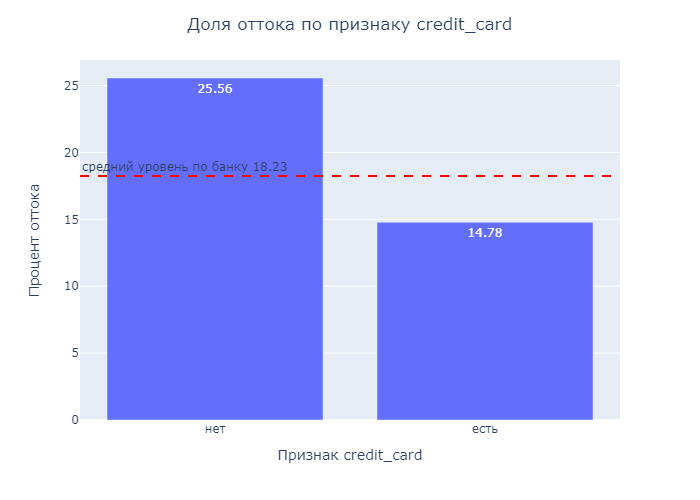

In [33]:
# построим диаграмму по наличию кредитной карты
cat_features(data, 'credit_card')

В отток попала четверть клиентов без кредитной карты, среди обладателей кредитных карт доля оттока составляет чуть менее 15%.

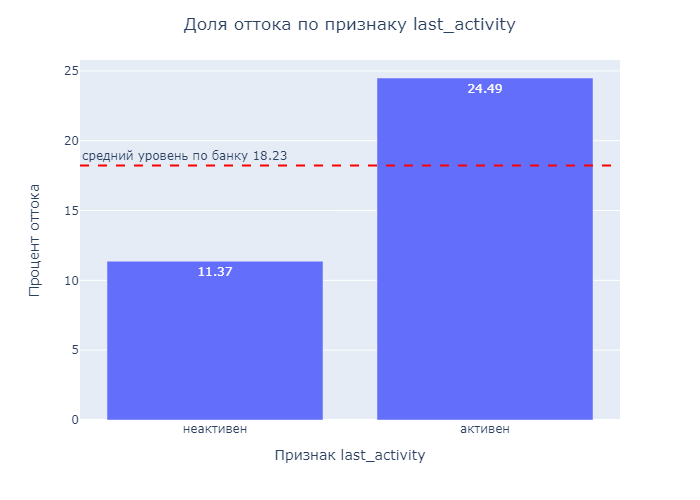

In [34]:
# построим диаграмму по активности
cat_features(data, 'last_activity') 

Среди клиентов, которые были активны в последнее время, доля оттока составляет 24,5%. В то же время у неактивных клиентов доля оттока гораздо ниже - 11,37%.

#### Корреляционный анализ

Построим тепловую карту на базе таблицы корреляции для изучения взаимосвязи разных параметров.

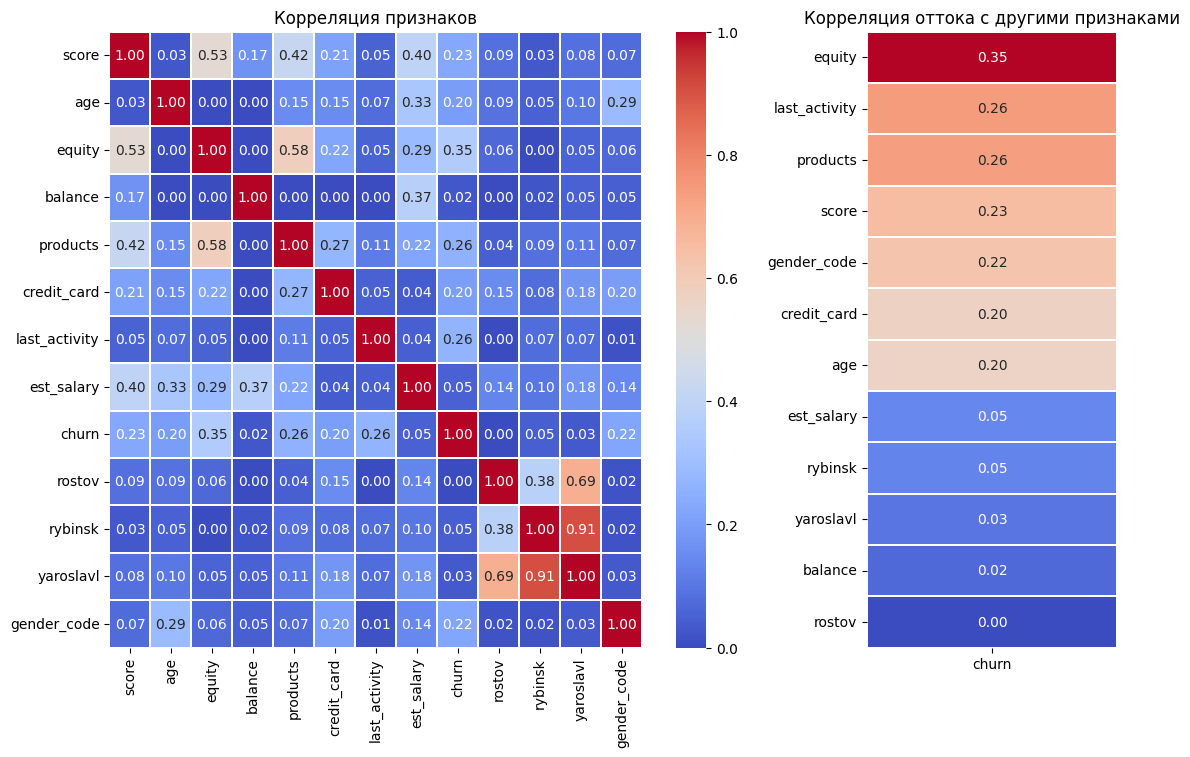

In [35]:
# рассчитаем матрицу корреляции
data_phik_matrix = (
    data
    .drop(columns=['userid', 'city', 'gender', 'balance_missing'], axis=1)# уберем ненужные столбцы
    .phik_matrix(interval_cols=['score', 'balance', 'est_salary'])
)

# построим тепловую карту параметров по матрице корреляции
fig, axes = plt.subplots(nrows=1, 
                         ncols=2, 
                         figsize=(13, 8), 
                         gridspec_kw=dict(width_ratios=[8, 3]))# зададим размер карты
# общая тепловая карта
sns.heatmap(
    data_phik_matrix, 
    cmap='coolwarm',
    fmt='.2f',
    linewidths=.3,
    annot=True,
    ax=axes[0]
)
axes[0].set_title('Корреляция признаков')
# тепловая карта оттока
sns.heatmap(
    data_phik_matrix
    .loc[:,['churn']]
    .drop('churn')
    .sort_values('churn', ascending=False), 
    cmap='coolwarm',
    fmt='.2f',
    linewidths=.3,
    annot=True,
    cbar=False,
    ax=axes[1]
)
axes[1].set_title('Корреляция оттока с другими признаками')
fig.show();

Оценим полученную карту по шкале корреляции Чеддока:
* 0 – полное отсутствие связи
* 0 – 0.3 – очень слабая
* 0.3 – 0.5 – слабая
* 0.5 – 0.7 – средняя
* 0.7 – 0.9 – высокая
* 0.9 – 1 – очень высокая

В соответствии с ней между фактом оттока и каким-либо иным признаком нет выраженной зависимости. Слабую зависимость (0,35) можно отметить для признака оценки собственности. С остальными признаками у оттока взаимосвязь еще меньше: 0,26 для информации об активности и количестве продуктов, 0,23 для кредитного рейтина, 0,22 для пола, по 0,20 для информации о возрасте и наличии кредитной карты. По остальным признакам корреляция стремится к нулю. Среди признаков целом (безотносительно оттока) наиболее явная (средняя) корреляция наблюдается между оценкой собственности и кредитным скорингом, а также количеством продуктов.

**Итоги исследователького анализа данных**:
1. У отточных клиентов в среднем выше баланс, баллы собственности и активность.
2. Доля оттока выше при кредитном рейтинге около 820-910, в возрастах 23-35 и 50-60. Оценочный доход в разрезе оттока в целом сопоставим, доля оттока немного выше в промежутке 100-200 тыс.
3. Отток в разрезе городов примерно одинаковый, сопоставим со средним по банку. Среди мужчин доля оттока значительно выше, чем среди женщин. Также доля оттока растет по мере увеличения балла собственности и числа продуктов. К оттоку более склонны клиенты, не имеющие кредитных карт, и также наиболее активные клиенты.
4. Выраженной корреляции между оттоком и другими признаками нет. Однако можно заметить, что такая группа признаков как ~баланс~ кредитный рейтинг, баллы собственности, количество продуктов связаны друг с другом и опосредованно влияют на отток.

Судя по полученной информации, в отток чаще попадают клиенты муского пола с бОльшим балансом, баллами собственности и числом продуктов, не имеющие кредитных карт, но при этом активно пользующиеся банковскими продуктами. Если наличие кредитной карты может выступать неким "якорем", препятствующим оттоку, то вопрос о сильном оттоке активных клиентов с большим числом продуктов более интересный. Возможно, у таких клиентов из-за их активности накапливается больше негативного опыта общения с банком. Также интересен отток среди клиентов с высоким балансом и высокими баллами собственности. Можно предположить, что люди с накоплениями уходят к конкурентам, предлагающим более выгодные условия.

### <a id="hypotheses">Проверка гипотез, связанных с оттоком</a>

По результатам исследовательского анализа данных кажется уместным несколько изменить гипотезы, предложенные на этапе декомпозиции.

#### Гипотеза о разнице в доходах отточных и неотточных клиентов

**Нулевая гипотеза**: разница в средних доходах отточных и неотточных клиентов не является статистически значимой<br>
**Альтернативная гипотеза**: между средними доходами отточных и неотточных клиентов есть статистически значимая разница

Для проверки гипотезы воспользуемся двумя критериями - Стьюдента и Манна-Уитни - и проверим, какой подойдет лучше для данной ситуации. Сначала изучим сами выборки.

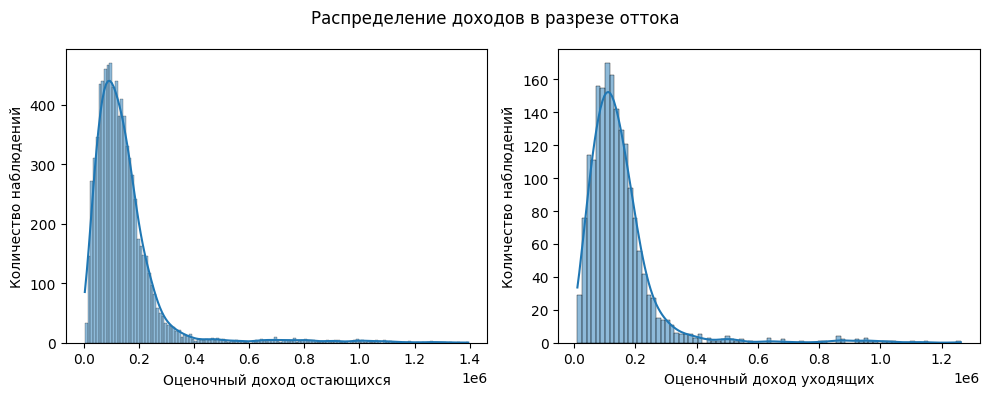

Стд. отклонение среди неотточных: 142684.4050271226
Стд. отклонение среди отточных: 122931.98187161624
p-значение:  0.0
Результат теста Шапиро: распределение не нормально


In [36]:
# построим гистограммы для оценки распределения дохода в разрезе оттока
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), tight_layout=True)
sns.histplot(data=data.query('churn == 0'), x='est_salary', kde=True, ax=axes[0])   
axes[0].set_xlabel('Оценочный доход остающихся')
axes[0].set_ylabel('Количество наблюдений')
sns.histplot(data=data.query('churn == 1'), x='est_salary', kde=True, ax=axes[1])
axes[1].set_xlabel('Оценочный доход уходящих')
axes[1].set_ylabel('Количество наблюдений')
plt.suptitle('Распределение доходов в разрезе оттока')
plt.show()
# посчитаем стандартное отклонение
print('Стд. отклонение среди неотточных:', data.query('churn == 0')['est_salary'].std())
print('Стд. отклонение среди отточных:', data.query('churn == 1')['est_salary'].std())

# проверим данные на нормальность распределения
alpha = .05 # критический уровень статистической значимости
results = st.shapiro(data['est_salary'])
p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Результат теста Шапиро: распределение не нормально")
else:
    print("Результат теста Шапиро: распределение нормально")

Внешний вид гистограмм указывает на смещенное нормальное распределение, однако в обеих выборках много выбросов, а стандартное отклонение слишком велико. На ненормальность распределения указывают и результаты теста Шапиро-Уилка. Проверим гипотезы.

In [37]:
# проверка критерием Манна-Уитни
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(
    data.query('churn == 0')['est_salary'], 
    data.query('churn == 1')['est_salary'],
    alternative='two-sided'
)
print('p-значение по критерию Манна-Уитни: ', results.pvalue)
# проверяем p-value
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение по критерию Манна-Уитни:  0.00016830729188229058
Отвергаем нулевую гипотезу: разница статистически значима


In [38]:
# проверка критерием Стьюдента
# зададим уровень значимости
alpha = 0.05

# посчитаем дисперсии отдельно
results = st.ttest_ind(
    data.query('churn == 0')['est_salary'], 
    data.query('churn == 1')['est_salary'], 
    equal_var=False, alternative='two-sided'
)

print(f'p-значение по критерию Стьюдента: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение по критерию Стьюдента: 0.8354803526840116
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


При проверке гипотезы двумя критериями мы получили диаметрально противоположные результаты: по Манну-Уитни разница статистически значима, по Стьюденту вывод о различий сделать нельзя.<br>
Чтобы понять, какому критерию все-таки стоит доверять, вспомним условия применения критериев:<br>
Для Стьюдента:
- данные должны быть нормально распределены
- данные должны быть количественными
- выборки независимые<br>

В данном случае из-за большого количества выбросов первое условие не соблюдается. Критерий Манна-Уитни не требует нормального распределения, он ранжирует две выборки по порядку от меньшего к большему и сравнивает ранги одних и тех же значений, попавших в обе выборки. Однако у него есть ограничения:
- в каждой из выборок должно быть не менее 3 значений признака (с этим у нас проблем нет)
- в каждой выборке должно быть не более 60 значений параметра, иначе ранжирование становится довольно трудоемким (в разных источниках указывается разное число значений, но суть понятна)<br>

В данной гипотезе мы проверяем равенство средних для непрерывного признака, то есть у нас значений параметра очень много. Манн-Уитни оценивает разницу между рангами одних и тех же значений в двух выборках. Если разница одинаковая, говорят о типичном сдвиге, когда просто добавились значения, сдвинувшие все остальные. Но чем больше различий обнаруживается в разнице между рангами, тем, по критерию Манна-Уитни, больше вероятность, что
для взятых выборок интересующая нас величина различается. Тогда неудивительно, что в данном случае, т.е. при наличии очень большого числа значений признака, Манн-Уитни обнаружил статистически значимые различия.<br>
В то же время центральная предельная теорема говорит нам о том, что выборочное распределение выборочного среднего будет стремиться к нормальному по мере роста размера выборки. То есть чем больше выборка, тем ближе математическое ожидание к истинному среднему. Таким образом, размер выборки должен нивелировать влияние выбросов.<br>
Однако в данном случае выбросов очень много и их часть сильно удалена от среднего, то есть они оказывают слишком большое влияние на выборку. Плюс сами данные распределены ненормально. Следовательно, стоит отдать предпочтение критерию Манна-Уитни, согласно которому разница в доходах отточных и неотточных клиентов является статистически значимой.

#### Гипотеза о том, что отточные клиенты пользуются  большим числом продуктов

**Нулевая гипотеза**: среднее число продуктов у отточных и неотточных клиентов одинаковое<br>
**Альтернативная гипотеза**: у отточных клиентов число продуктов в среднем больше<br>

Построим распределения числа продуктов по отточным и неотточным клиентам для определения параметров статистической проверки.

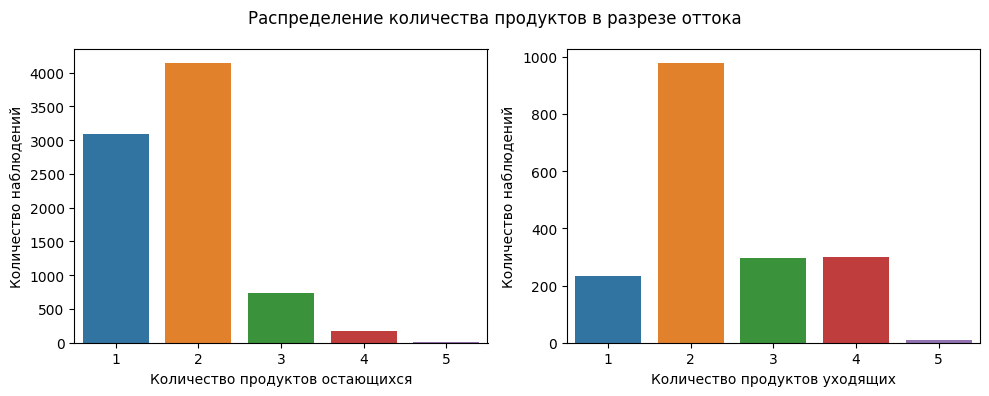

Стд. отклонение среди неотточных: 0.7134124917383494
Стд. отклонение среди отточных: 0.9221622536960059


In [39]:
# построим каунтплоты для оценки распределения количества продуктов в разрезе оттока
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), tight_layout=True)
sns.countplot(data=data.query('churn == 0'), x='products', ax=axes[0])   
axes[0].set_xlabel('Количество продуктов остающихся')
axes[0].set_ylabel('Количество наблюдений')
sns.countplot(data=data.query('churn == 1'), x='products', ax=axes[1])
axes[1].set_xlabel('Количество продуктов уходящих')
axes[1].set_ylabel('Количество наблюдений')
plt.suptitle('Распределение количества продуктов в разрезе оттока')
plt.show()
# посчитаем стандартное отклонение
print('Стд. отклонение среди неотточных:', data.query('churn == 0')['products'].std())
print('Стд. отклонение среди отточных:', data.query('churn == 1')['products'].std())

Здесь нельзя говорить о нормальном распределении, а стандартное отклонение в обоих случаях велико для имеющихся значений. Также мы имеем дело с категориальными данными. То есть в данном случае скорее применим критерий Манна-Уитни.

In [40]:
# проверка односторонним критерием Манна-Уитни
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(
    data.query('churn == 1')['products'], 
    data.query('churn == 0')['products'],
    alternative='greater'
)
print('p-значение по критерию Манна-Уитни: ', results.pvalue)
# проверяем p-value
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: у отточных клиентов число продуктов в среднем больше")
else:
    print("Не получилось отвергнуть нулевую гипотезу: среднее число продуктов у отточных и неотточных клиентов одинаковое")

p-значение по критерию Манна-Уитни:  5.906363305985951e-162
Отвергаем нулевую гипотезу: у отточных клиентов число продуктов в среднем больше


Сделанный ранее вывод о большем количестве продуктов у отточных клиентов подтверждается статистически.

#### Гипотеза о том, что у отточных клиентов больше баланс

**Нулевая гипотеза**: средний баланс у отточных и неотточных клиентов одинаковый<br>
**Альтернативная гипотеза**: у отточных клиентов баланс в среднем выше<br>

Построим распределения баланса по отточным и неотточным клиентам для определения параметров статистической проверки. 

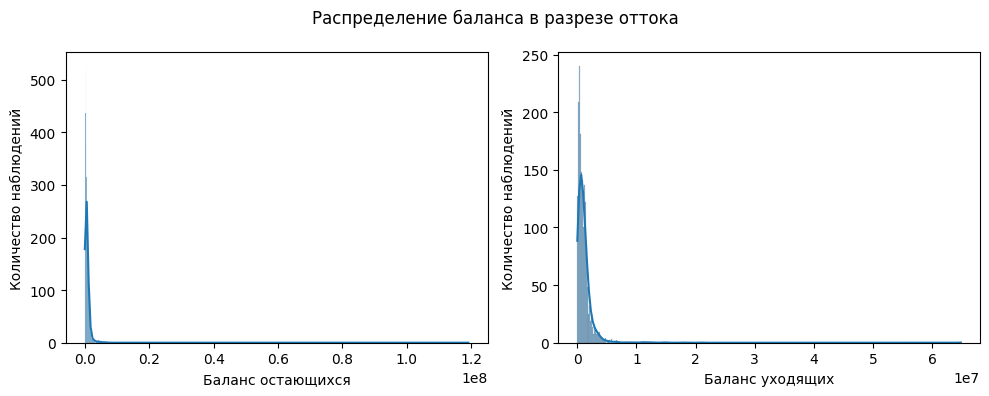

Стд. отклонение среди неотточных: 1953952.4827626687
Стд. отклонение среди отточных: 2034445.548690327
p-значение:  1.0
Результат теста Шапиро: распределение нормально


In [41]:
# построим гистограммы для оценки распределения баланса в разрезе оттока
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), tight_layout=True)
sns.histplot(data=data.query('churn == 0'), x='balance', kde=True, ax=axes[0])   
axes[0].set_xlabel('Баланс остающихся')
axes[0].set_ylabel('Количество наблюдений')
sns.histplot(data=data.query('churn == 1'), x='balance', kde=True, ax=axes[1])
axes[1].set_xlabel('Баланс уходящих')
axes[1].set_ylabel('Количество наблюдений')
plt.suptitle('Распределение баланса в разрезе оттока')
plt.show()
# посчитаем стандартное отклонение
print('Стд. отклонение среди неотточных:', data.query('churn == 0')['balance'].std())
print('Стд. отклонение среди отточных:', data.query('churn == 1')['balance'].std())

# проверим данные на нормальность распределения
alpha = .05 # критический уровень статистической значимости
results = st.shapiro(data['balance'])
p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Результат теста Шапиро: распределение не нормально")
else:
    print("Результат теста Шапиро: распределение нормально")

Диаграммы визуально похожи на распределение оценочного дохода. Стандартные отклонения велики. Тем не менее, результаты теста Шапиро-Уилка указывают на нормальность распределения. Возможно, дело в том, что в данном случае выбросов не слишком много относительно всей выборки. Воспользуемся односторонним критерием Стьюдента.

In [42]:
# проверка критерием Стьюдента
# зададим уровень значимости
alpha = 0.05

# посчитаем дисперсии отдельно
results = st.ttest_ind(
    data.query('churn == 1')['balance'], 
    data.query('churn == 0')['balance'], 
    equal_var=False, nan_policy='omit', alternative='greater'
)

print(f'p-значение по критерию Стьюдента: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: у отточных клиентов баланс в среднем выше')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение по критерию Стьюдента: 8.658704289556784e-14
Отвергаем нулевую гипотезу: у отточных клиентов баланс в среднем выше


Снова статистически подтверждается сделанное ранее наблюдение: баланс у отточных клиентов в среднем несколько выше.

Таким образом, статистическая проверка гипотез показала следующее:
- разница в доходе отточных и неотточных клиентов статистически значима
- у отточных клиентов статистически в среднем выше баланс и они пользуются большим числом продуктов.

### <a id="segmenting">Сегментация</a>

Выделим сегменты клиентов, наиболее склонных к оттоку, памятуя, что средний отток по банку составляет около 18%.

In [43]:
# найдем долю оттока среди активных клиентов с высоким балансом и доходом
(
    data
    .query('balance > 750000 and est_salary > 100000 and last_activity == 1')
    .agg({"churn":["mean","sum","count"]})
)

,churn
mean,0.58
sum,560.00
count,973.00


**Сегмент 1**: активные клиенты с балансом > 750тыс и оценочным доходом > 100тыс. В сегмент попали 973 клиента, т.е. чуть меньше 10% от всего датасета, а уровень оттока в сегменте составляет целых 58%. Таким образом, массово уходят активные клиенты со значительными накоплениями и доходом выше среднего (на начало 2024 года разные источники указывают среднюю зп по Ярославской области в диапазоне 50-70т). Можно предположить, что таких клиентов кардинально не устраивают, например, условия хранения средств на счетах, и они уходят в банки с более выгодными условиями для уровня их трат и накоплений. Тогда для удержания таких клиентов можно предложить более привлекательные условия по накопительным программам и кешбэку. Например, с дифференциацией в зависимости от уровня трат или количества средств на депозите. Также этим клиентам можно предложить инвестиционные программы.

In [44]:
# найдем долю оттока среди мужчин с высоким кредитным рейтингом без кредитрных карт
(
    data
    .query('800 <= score <=950 and gender == "М" and credit_card == 0')
    .agg({"churn":["mean","sum","count"]})
)

,churn
mean,0.40
sum,420.00
count,1038.00


**Сегмент 2**: 1038 клиентов (примерно 10,4%) - мужчины без кредитных карт с хорошим кредитным рейтингом. Здесь наиболее очевидным решением будет предложение разных кредитных программ, включая кредитные карты и перекредитование (при наличии кредита в другом банке).

In [45]:
# найдем долю оттока среди активных клиентов экономически активного возраста с высоким баллом собственности
(
    data
    .query('25 <= age <= 60 and equity >= 4 and last_activity == 1')
    .agg({"churn":["mean","sum","count"]})
)

,churn
mean,0.43
sum,808.00
count,1892.00


**Сегмент 3**: 1892 клиента (около 19%) - активные клиенты экономически активного возраста с баллом собственности от 4 и выше. Для их удержания можно предложить перевести в банк зарплатный счет (с предоставлением каких-то выгод, например, по кредитованию) или предложить специальные условия по страхованию имущества, накопительные и инвестиционные продукты.

In [46]:
# найдем долю оттока среди клиентов с большим количеством продуктов, хорошим кредитным рейтингом и доходом >= 40000
(
    data
    .query('products >= 3 and est_salary >= 40000  and score >= 800')
    .agg({"churn":["mean","sum","count"]})
)

,churn
mean,0.47
sum,507.00
count,1086.00


**Сегмент 4**: если смотреть по одному признаку (количество продуктов от 3 и больше), отточность в нем - 40% при том, что туда попал 1531 клиент (около 15%). Вместе с тем само наличие 3 и более продуктов не кажется чем-то сверхъестественным. Возникло предположение, что многие клиенты одновременно пользуются продуктами нескольких банков и в случае, например, более выгодных условий в банках-конкурентах просто переходят туда. При этом доля оттока становится выше средней по банку при доходе от 40000 и выше, т.е. имеет смысл ограничить маркетинговые мероприятия этим значением. Дополнительно повышает долю оттока высокий кредитный рейтинг. Таким образом, в сегменте 4 остались 1086 клиентов с большим количеством продуктов и высоким кредитным рейтингом, зарабатывающие больше 40000. Отток - 47%. С учетом предположения, что речь может идти о клиентах нескольких банков, которые в итоге выбирают банки с условиями получше, можно порекомендовать следующее (в зависимости от характера продуктов):
- предложение перевода зарплатного счета (если в другом банке) с предоставлением каких-то преимуществ
- пересмотр условий по действующим продуктам
- предложение заменить действующие, но переставшие быть привлекательными продукты, другими, более подходящими клиенту
- поскольку в сегменте клиенты с хорошим кредитным рейтингом - предложение перекредитования (при наличии кредитов в другом банке)

**Промежуточные итоги**:<br>
Опираясь на более склонные к оттоку интервалы отдельных признаков, мы выделили 4 сегмента (в порядке убывания приоритета):
- *сегмент 1*: активные клиенты с доходом > 100 тыс и балансом > 750тыс. Доля оттока 58%, кол-во клиентов - 973 (ок. 10% датасета). Очень высокоотточный сегмент, доля оттока в котором растет по мере увеличения дохода и баланса. Причина приоритизации: очень высокая доля оттока среди наиболее платежеспособной категории клиентов. Предложения по удержанию:
    - более привлекательные условия по накопительным программам
    - повышенный кешбэк с дифференциацией по уровню трат
    - инвестиционные программы
- *сегмент 4*: клиенты с 3 и более продуктами, доходом >= 40тыс и кредитным рейтингом >= 800. Доля оттока 47%, кол-во клиентов - 1086 (ок. 11% датасета). Высокоотточный сегмент в основном из-за количества продуктов. Предположение: одновременное использование продуктов нескольких банков => отток в банки с более удобными продуктами / выгодными условиями. Причина приоритизации: очень высокая доля оттока; если предположение о нескольких банках верно - хорошие шансы удержать клиентов за счет повышения качества/удобства продуктов. Предложения по удержанию:
    - предложение перевода зарплатного счета (если в другом банке) с предоставлением дополнительных преимуществ
    - пересмотр условий по действующим продуктам
    - предложение заменить действующие, но переставшие быть привлекательными продукты, другими, более подходящими клиенту
    - предложение перекредитования (при наличии кредитов в другом банке)
- *сегмент 3*: активные клиенты в возрасте 25-60 лет с баллом собственности >= 4. Доля оттока 43%, кол-во клиентов - 1892 (ок. 19% датасета). Экономически активный сегмент со средне-высоким уровнем собственности. Причина снижения приоритета: доля оттока ниже, большая группа - меры по удержанию могут быть не такими эффективными. Предложения по удержанию:
    - предложение перевода зарплатного счета (если в другом банке) с предоставлением дополнительных преимуществ
    - специальные условия по страхованию имущества, ДМС (если есть такие программы)
    - накопительные и инвестиционные продукты, в том числе направленные на формирование "пенсии"
- *сегмент 2*: мужчины без кредитных карт с рейтингом 800-950. Доля оттока 40%, кол-во клиентов - 1038(ок. 10,4%). Сегмент выбран из-за большей склонности мужчин к оттоку, однако причины разницы оттока в разрезе пола могут быть самыми разными, в том числе психосоциальными. Мы обратили внимание на существенный рост доли оттока у мужчин без кредитных карт с хорошим кредитным рейтингом. Предложения по удержанию:
    - предложение разных кредитных программ, включая кредитные карты и перекредитование (при наличии кредита в другом банке)

### <a id="summary">Выводы и рекомендации</a>

Мы проанализировали данные об оттоке клиентов банка. Задача состояла в выявлении сегментов клиентов, склонных к оттоку, и формировании рекомендаций по их удержанию для отдела маркетинга.<br>

В рамках исследовательского анализа данных сравнили показатели отточных и неотточных клиентов и установили следующее:
1. У отточных клиентов в среднем выше баланс, баллы собственности и активность.
2. Доля оттока выше при:
    - кредитном рейтинге в диапазоне 820-910 
    - в возрастах 23-35 и 50-60
    - уровне оценочного дохода 100-200 тыс
    - балансе примерно от 750тыс и выше
    - среди мужчин 
    - количестве продуктов от 3 и больше
    - баллах собственности от 4 и выше
    - отсутствии кредитных карт
    - наличии активности в последнее время
3. Выраженной корреляции между оттоком и другими признаками нет. Однако можно заметить, что такая группа признаков как кредитный рейтинг, баллы собственности, количество продуктов связаны друг с другом и опосредованно влияют на отток.

Таким образом, в отток чаще попадают люди с хорошим кредитным рейтингом, высоким балансом, большим числом продуктов и высокими баллами собственности, которые активно пользуются банковскими продуктами, но не имеют кредитных карт. Среди мужчин отточных почти в два раза больше, чем женщин (23,7% против 12,75%).<br>

Опираясь на полученную информацию, мы проверили статистическими методами несколько гипотез:
1. Гипотеза о равенстве доходов отточных и неотточных клиентов. На диаграммах разница в доходах почти не видна за исключением диапазона 100-200 тыс, где доля оттока чуть выше. Проведенная проверка показала, что эта разница статистически значима.
2. Гипотеза о том, что отточные клиенты в среднем пользуются большим числом продуктов. Мы обратили внимание на увеличение доли оттока по мере роста числа продуктов, и проверили предположение статистически. Гипотеза подтвердилась.
3. Гипотеза о том, что у отточных клиентов в среднем больше баланс. Здесь гипотеза также выдвигалась на основании разницы, обнаруженной в ходе EDA, и была подтверждена статистически.

Изучив данные, распределения показателей и проверив гипотезы, мы выделили несколько сегментов клиентов с высокими долями оттока и расположили их в порядке убывания приоритета:
1. **Сегмент 1**: активные клиенты с доходом > 100 тыс и балансом > 750тыс. Доля оттока 58%, кол-во клиентов - 973 (ок. 10% датасета). Очень высокоотточный сегмент, доля оттока в котором растет по мере увеличения дохода и баланса. Причина приоритизации: очень высокая доля оттока среди наиболее платежеспособной категории клиентов. Предложения по удержанию:
    - более привлекательные условия по накопительным программам
    - повышенный кешбэк с дифференциацией по уровню трат
    - инвестиционные программы
2. **Сегмент 4**: клиенты с 3 и более продуктами, доходом >= 40тыс и кредитным рейтингом >= 800. Доля оттока 47%, кол-во клиентов - 1086 (ок. 11% датасета). Высокоотточный сегмент в основном из-за количества продуктов. Предположение: одновременное использование продуктов нескольких банков => отток в банки с более удобными продуктами / выгодными условиями. Причина приоритизации: очень высокая доля оттока; если предположение о нескольких банках верно - хорошие шансы удержать клиентов за счет повышения качества/удобства продуктов. Предложения по удержанию:
    - предложение перевода зарплатного счета (если в другом банке) с предоставлением дополнительных преимуществ
    - пересмотр условий по действующим продуктам
    - предложение заменить действующие, но переставшие быть привлекательными продукты, другими, более подходящими клиенту
    - предложение перекредитования (при наличии кредитов в другом банке)
3. **Сегмент 3**: активные клиенты в возрасте 25-60 лет с баллом собственности >= 4. Доля оттока 43%, кол-во клиентов - 1892 (ок. 19% датасета). Экономически активный сегмент со средне-высоким уровнем собственности. Причина снижения приоритета: доля оттока ниже, большая группа - меры по удержанию могут быть не такими эффективными. Предложения по удержанию:
    - предложение перевода зарплатного счета (если в другом банке) с предоставлением дополнительных преимуществ
    - специальные условия по страхованию имущества, ДМС (если есть такие программы)
    - накопительные и инвестиционные продукты, в том числе направленные на формирование "пенсии"
4. **Сегмент 2**: мужчины без кредитных карт с рейтингом 800-950. Доля оттока 40%, кол-во клиентов - 1038 (ок. 10,4%). Сегмент выбран из-за большей склонности мужчин к оттоку, однако причины разницы оттока в разрезе пола могут быть самыми разными, в том числе психосоциальными. Существенный рост доли оттока у мужчин без кредитных карт с хорошим кредитным рейтингом. Предложения по удержанию:
    - предложение разных кредитных программ, включая кредитные карты и перекредитование (при наличии кредита в другом банке)